In [ ]:
!git clone https://github.com/HamishGBrown/Cryo_EM_theory.git
from google.colab import output
%%capture
!pip install ipympl
%cd Cryo_EM_theory

output.enable_custom_widget_manager()


Welcome to the intro to Fourier transforms Ipython Notebook where introductory Fourier transform concepts will be introduced.

First we demonstrate the how a single pixel within a Fourier transform corresponds to a Cosine (or sine) function in real-space:

IntSlider(value=1, description='x:', max=64, min=-64)

IntSlider(value=0, description='y:', max=64, min=-64)

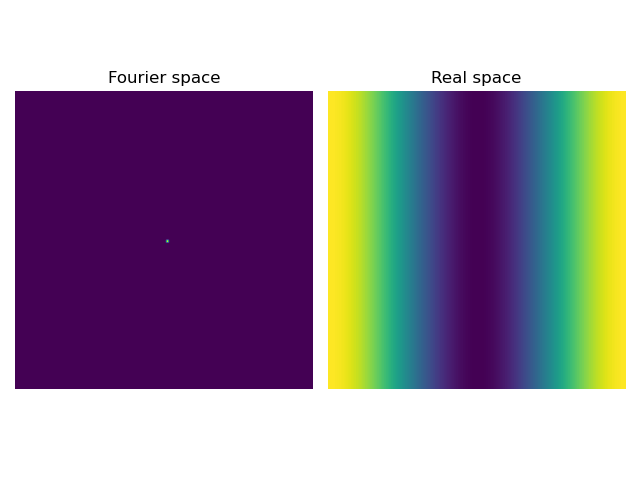

In [1]:
# for creating a responsive plot
%matplotlib widget
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt

# make plots
pix = 128 # number of pixels in image
FFT = np.zeros((pix,pix),dtype=complex) # initialize array
FFT[0,1] = 1 # Set one of its pixels to 1
iFFT = np.fft.ifft2(FFT) # take the inverse Fourier transform

# Now plot the FFT and the inverse FFT
fig,ax = plt.subplots(ncols=2)
im1 = ax[0].imshow(np.fft.ifftshift(np.real(FFT))) # What's with the FFT shift?
im2 = ax[1].imshow(np.real(iFFT))

# Pretty up plot
ax[0].set_axis_off()
ax[1].set_axis_off()
titles= ['Fourier space','Real space']
fig.tight_layout()
for a,title in zip(ax,titles): a.set_title(title)

def update_FFT(change):
    """Function to update plot when slider changes"""
    # Get new x and y values from sliders
    x,y = [slider_x.value,slider_y.value]
    
    # Update arrays with new values
    FFT[:] = 0
    FFT[y,x] = 1
    iFFT = np.fft.ifft2(FFT)
    im1.set_data(np.fft.ifftshift(np.real(FFT)))
    im2.set_data(np.real(iFFT))
    

# Create the rot position slider
slider_x = widgets.IntSlider(value=1, min=-pix//2, max=pix//2, step=1, description='x:')

# Create the tilt position slider
slider_y = widgets.IntSlider(value=0, min=-pix//2, max=pix//2, step=1, description='y:')

# Connect sliders to update function
slider_x.observe(update_FFT, names='value')
slider_y.observe(update_FFT, names='value')

#Display sliders
display(slider_x)
display(slider_y)


So what does the Fourier transform of a more complicated object (eg. a Racoon) look like?

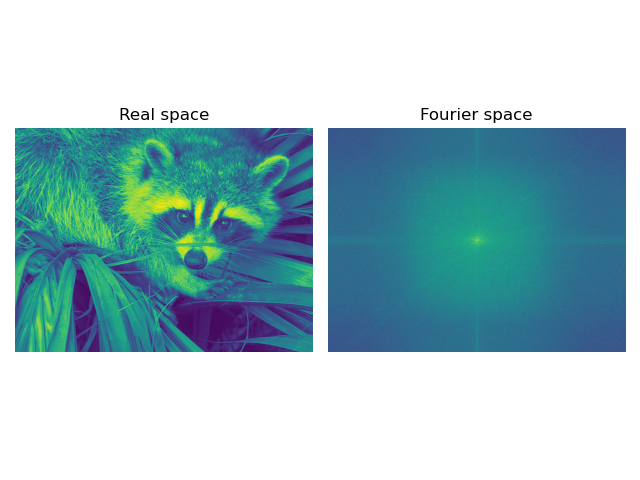

In [2]:
import scipy.datasets

# Get an image, in this case an image of a Racoon
face = np.sum(scipy.datasets.face(),axis=2)

# Plot Racoon with it's FFT
fig,ax = plt.subplots(ncols=2)
ax[0].imshow(face)
ax[1].imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(face))))) # What happens if the logarithm function is removed?

titles= ['Real space','Fourier space']
for a,title in zip(ax,titles): a.set_title(title)
for a in ax: a.set_axis_off()
fig.tight_layout()

What would happen if we modified (eg. masked out) values in the Fourier transform?

IntRangeSlider(value=(0, 512), description='Filter bounds', max=512)

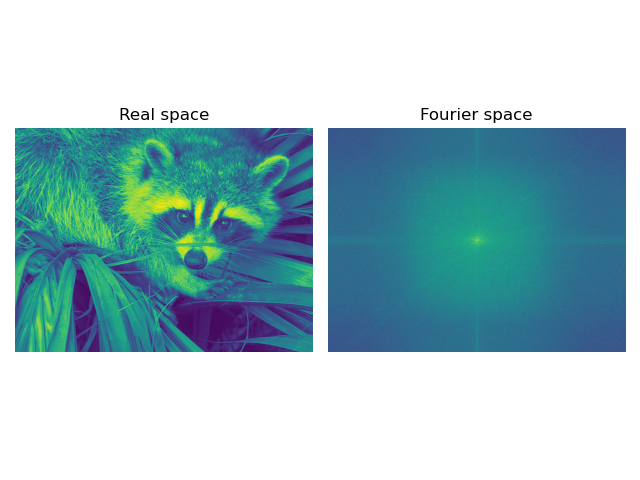

In [4]:

face = np.sum(scipy.datasets.face(),axis=2)
pix = max(face.shape)

fig,ax = plt.subplots(ncols=2)
im1 = ax[0].imshow(face)
im2 =ax[1].imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(face)))))
titles= ['Real space','Fourier space']
for a,title in zip(ax,titles): a.set_title(title)
for a in ax: a.set_axis_off()
fig.tight_layout()

def Fourier_filter(shape,radius):
    
    y,x = [np.fft.fftfreq(i,1/i) for i in shape]
    lowpass = (x**2)[None,:] + (y**2)[:,None] +0.1 < radius[1]**2
    highpass = (x**2)[None,:] + (y**2)[:,None] +0.1 > radius[0]**2
    return np.logical_and(lowpass,highpass).astype(int)
    
def update_FFT(change):
    """Function to update plot when slider changes"""
    low,high = filterslider.value
    filt =  Fourier_filter(face.shape,[low,high])

    iFFT = np.fft.ifft2(np.fft.fft2(face)*filt)
    im2.set_data(np.fft.fftshift(np.log(np.abs(np.fft.fft2(face)))*filt))
    im1.set_data(np.real(iFFT))
    im1.set_clim(vmin=np.real(iFFT).min(),vmax=np.real(iFFT).max())

    

# Create the low-pass slider
filterslider = widgets.IntRangeSlider(value=[0,pix//2],min=0,max=pix//2,step=1,description='Filter bounds')


# Connect sliders to update function
filterslider.observe(update_FFT, names='value')

#Display sliders
display(filterslider)


There are some handy tricks that will be helpful in data processing that can be done really quickly with Fourier transforms. An example is the convolution and, if two arrays A and B are convolved, this is equivalent to placing one copy of function B at every non-zero point in A. This can be achieved by multiplying two functions in Fourier space:

5.0


Dropdown(options=('Points', 'Square', 'Circle'), value='Points')

Dropdown(index=1, options=('Points', 'Square', 'Circle'), value='Square')

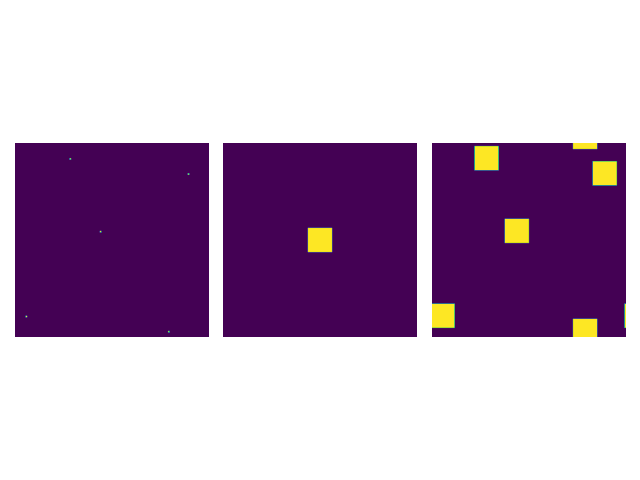

In [5]:
def convolve(array1,array2):
    return np.real(np.fft.ifft2(np.fft.fft2(array1)*np.fft.fft2(array2)))


pix = 128
array = np.zeros((pix,pix))
rng = np.random.default_rng()
points= rng.integers(pix, size=(5,2))
for x,y in points:
    array[y,x] = 1
print(np.sum(array))

r = pix // 8
square = np.zeros((pix,pix))
square[:r,:r]=1
square = np.roll(square,[(-r)//2]*2,axis=(0,1))

circle = Fourier_filter([pix,pix],[0,r//2])

options = ['Points','Square','Circle']

def update(change):
    val1 = drop1.value
    val2 = drop2.value
    
    def get_im(val):
        if val=='Points':
            return array
        elif val=='Square':
            return square
        elif val=='Circle':
            return circle
        
    img1 = get_im(val1)
    img2 = get_im(val2)
    
    im1.set_data(np.fft.ifftshift(img1))
    im2.set_data(np.fft.ifftshift(img2))
    conv = convolve(img1,img2)
    im3.set_data(np.fft.ifftshift(conv))
    im3.set_clim(vmin=conv.min(),vmax=conv.max())

drop1 = widgets.Dropdown(options=options,value='Points')
drop2 = widgets.Dropdown(options=options,value='Square')

# Connect sliders to update function
drop1.observe(update, names='value')
drop2.observe(update, names='value')

fig,ax = plt.subplots(ncols=3)
im1 = ax[0].imshow(np.fft.ifftshift(array))
im2 = ax[1].imshow(np.fft.ifftshift(square))
im3 = ax[2].imshow(np.fft.ifftshift(convolve(array,square)))

for a in ax: a.set_axis_off()
fig.tight_layout()
display(drop1)
display(drop2)

Effectively the convolution is the blurring of one function (eg. a Racoon) with another (eg. a Gaussian function):

FloatSlider(value=1.0, description='Gaussian blur (pix):', min=1.0, step=0.25)

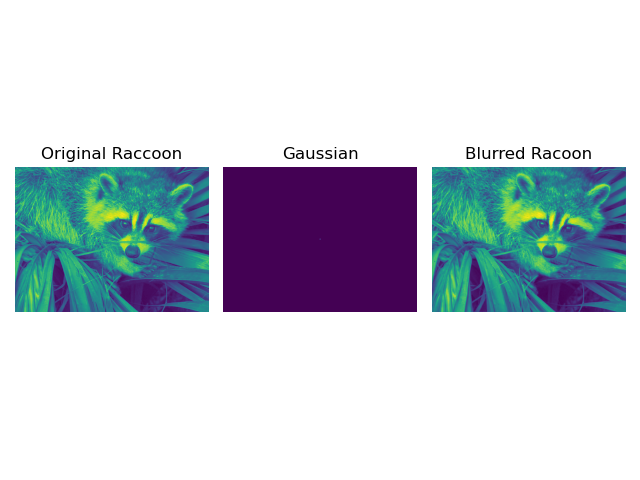

In [24]:
import scipy.misc
from functions import *

face = np.sum(scipy.misc.face(),axis=2)
pix = max(face.shape)

fig,ax = plt.subplots(ncols=3)
ax[0].imshow(face)
im2 =ax[1].imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(face)))))
im1 = ax[2].imshow(face)
titles= ['Original Raccoon','Gaussian','Blurred Racoon']
for a,title in zip(ax,titles): a.set_title(title)
for a in ax: a.set_axis_off()
fig.tight_layout()

    
def update_gaussian(change):
    """Function to update plot when slider changes"""
    sigma = slider_gaussian.value
    s = face.shape
    gauss = Gaussian(sigma, s, s)

    iFFT = np.fft.ifft2(np.fft.fft2(face)*np.fft.fft2(gauss))
    im2.set_data(np.fft.fftshift(gauss))
    im1.set_data(np.real(iFFT))
    im1.set_clim(vmin=np.real(iFFT).min(),vmax=np.real(iFFT).max())
    im2.set_clim(vmin=gauss.min(),vmax=gauss.max())

    

# Create the low-pass slider
slider_gaussian = widgets.FloatSlider(value=0, min=1, max=100, step=0.25, description='Gaussian blur (pix):')

# Connect sliders to update function
slider_gaussian.observe(update_gaussian, names='value')

#Display sliders
display(slider_gaussian)
update_gaussian(None)

A related Fourier type algorithm, the cross-correlation, is useful for finding different templates in a larger image. Let's apply our new algorithm knowledge to an age-old problem "Where's Wally?":

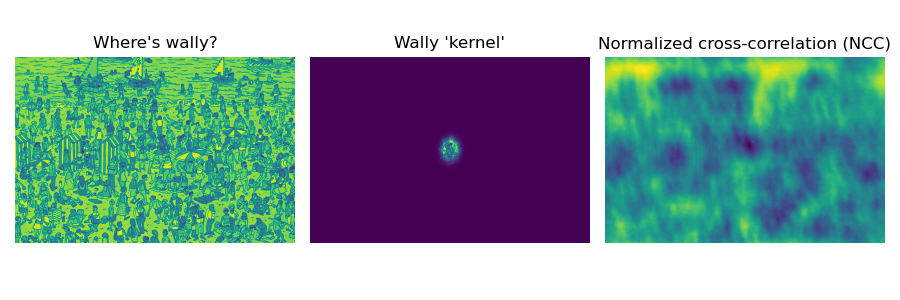

In [14]:
import imageio.v3 as iio
from scipy.signal import correlate as scipy_correlate

def pillbox(sigma,gridshape,rsize,cutoff):
    gauss = Gaussian(sigma, gridshape, rsize, theta=0)
    return np.clip(gauss/cutoff,0,1)

wally = np.sum(iio.imread('wereswally.jpg'),axis=2)
y,x =wally.shape
wally_kernel = np.zeros_like(wally)
wally_kernel =np.roll(wally,[-270-32,-507-16],axis=(0,1))*pillbox([20,16],wally.shape,wally.shape,0.3)



def correlate(array1,array2):
    xcorr = np.real(np.fft.ifft2(np.fft.fft2(array1)*np.fft.fft2(array2).conj()))
    return xcorr/np.prod(array1.shape)/np.std(array1)/np.std(array2)

ncc = correlate(wally,wally_kernel)

fig,ax = plt.subplots(ncols=3,figsize=(9,3))
ax[0].imshow(wally)
ax[1].imshow(np.fft.ifftshift(wally_kernel))
ax[2].imshow(ncc)
titles = ["Where's wally?","Wally 'kernel'",'Normalized cross-correlation (NCC)']
for a,title in zip(ax,titles): a.set_title(title)
for a in ax:a.set_axis_off()
fig.tight_layout()


We can apply a threshhold and plot the points in the corresponding image to see how the cross-correlation might help us:

FloatRangeSlider(value=(0.2, 0.21), description='NCC threshhold', max=0.25, min=0.17, step=0.001)

ToggleButton(value=True, button_style='success', description='Plot threshhold?')

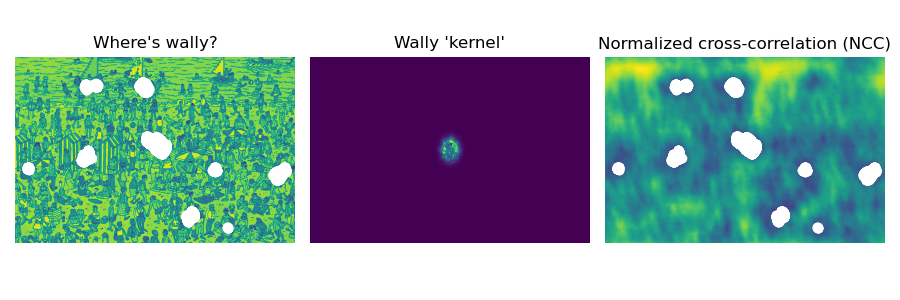

In [23]:
fig,ax = plt.subplots(ncols=3,figsize=(9,3))

ax[0].imshow(wally)
ax[1].imshow(np.fft.ifftshift(wally_kernel))
im3 =ax[2].imshow(correlate(wally,wally_kernel))
plt1, = ax[0].plot([],[],'wo')
plt2, = ax[2].plot([],[],'wo')

titles = ["Where's wally?","Wally 'kernel'",'Normalized cross-correlation (NCC)']
for a,title in zip(ax,titles): a.set_title(title)
for a in ax:a.set_axis_off()
fig.tight_layout()

def threshhold(change):
    low,high = slider.value
#     print(toggle.value)
    if toggle.value:
        points = np.asarray(np.nonzero(np.logical_and(ncc>=low, ncc<=high))).T
        plt1.set_data(points[:,1],points[:,0])
        plt2.set_data(points[:,1],points[:,0])
    else:
        plt1.set_data([],[])
        plt2.set_data([],[])

# Create the low-pass slider
slider = widgets.FloatRangeSlider(value=[0.2,0.21],min=0.17,max=0.25,step=0.001,description='NCC threshhold')

#toggle
toggle = widgets.ToggleButton(value=True,description='Plot threshhold?',button_style='success')

# Connect sliders to threshhold function
slider.observe(threshhold, names='value')
toggle.observe(threshhold, names='value')

#Display sliders
display(slider)
display(toggle)
threshhold(None)